## Introduction

Classification problems are some of the most common tasks in machine learning. The process is simple, usually starts by loading your data, label encoding categorical features, training a `MLPClassifier`, which is a neural network model, and predicting test results. In just 10 lines of code, you can achieve a baseline F1 score of 0.677.

What else we can do to have a better classification? In this article, I'll walk you through essential ML techniques for classification and beyond, like data preprocessing, hyperparameter tuning, dealing with unbalanced datasets and evaluating classification model performance.

On the business side, approving an **unqualified applicant** often costs more than rejecting a qualified one. I'll also show how to handle these misclassification costs using scikit-learn models.
Here's what we'll cover:

1. Understanding the Dataset
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing
4. Model Development and Selection
5. Model Evaluation and Improvement
6. Conclusion 

This step-by-step guide will not only introduce fundamental techniques but also equip you with practical knowledge to approach real-world classification problems.

In [82]:
# from google.colab import drive
# drive.mount('/content/drive')

In [83]:
# Settings
# project_folder = '/content/drive/MyDrive/Colab Notebooks/2024.12.19 Loan Prediction'

## 1. Necessary Packages

In [84]:
# pip install xgboost

In [85]:
# !pip3 install scikit-learn==1.5.2

In [86]:
# Data Processing and Linear Algebra Libraries
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing and Feature Engineering
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Evaluation Metrics and Visualization
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
    precision_recall_curve,
    PrecisionRecallDisplay
)

# Model Selection and Improvement Tools
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
import time

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [87]:
# Model Settings
RND = 42   # random seed
n_iter = 20 # number of iterations

**Baseline**

MLPClassifier (Multi-Layer Perceptron) is a neural network model

In [ ]:
# data = pd.read_csv(f"{project_folder}/dataset/train_loan.csv")
data = pd.read_csv(f"dataset/train_loan.csv")
data.dropna(inplace=True)
le = LabelEncoder()
for col in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term','Loan_Status']:
    data[col] = le.fit_transform(data[col])
X = data.drop(columns=['Loan_Status', 'Loan_ID'])
y = data['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RND)
model = MLPClassifier(random_state=RND)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy, 3)}")
print(f"F1 score: {round(f1, 3)}")

Accuracy: 0.5694444444444444
F1 score: 0.6770833333333334


## 1. Understanding the Dataset

In this project, we aim to create a prediction model that serves the banks to minimize risks and reduce the number of potential defaulters.

The dataset provided contains key applicant information that will be used to predict whether a loan request can be approved. Below are the features included in the dataset:

1. `Loan ID`: Unique identifier for each loan application (not used in prediction).
2. `Gender`: Male or Female.
3. `Married`: Applicant's marital status (Yes/No).
4. `Dependents`: Number of dependents the applicant has.
5. `Education`: Graduate or Non-Graduate status.
6. `Self Employed`: Whether the applicant is self-employed (Yes/No).
7. `Applicant Income`: The primary applicant's income.
8. `CoApplicant Income`: Income of a co-applicant (if any).
9. `Loan Amount`: Amount of the loan applied for.
10. `Loan Amount Term`: Duration of the loan in months.
11. `Credit History`: History of creditworthiness (1: Good, 0: Bad).
12. `Property Area`: Location of the property (Urban, Semi-Urban, or Rural).
13. `Loan Status`: Target variable indicating whether the loan was approved (Yes) or rejected (No).

**Objective**: Use the provided features to predict the `Loan Status` (Yes/No) for each application.

In [89]:
# train = pd.read_csv(f"{project_folder}/dataset/train_loan.csv")
# test  = pd.read_csv(f"{project_folder}/dataset/test_loan.csv")
train = pd.read_csv(f"dataset/train_loan.csv")
test  = pd.read_csv(f"dataset/test_loan.csv")

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


The training dataset contains 614 rows and 13 columns, while the test dataset has 367 rows and 12 columns.

The test dataset does not include the target variable, `Loan_Status`, which needs to be predicted. Consequently, we cannot directly verify prediction accuracy on the test data. For this project, we will focus on working with the training dataset.

In [90]:
train.shape, test.shape

((614, 13), (367, 12))

In [91]:
data = train
# Checking the bal of target variable
data["Loan_Status"].value_counts(normalize=True)

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

Analyzing the class distribution reveals a class imbalance: 69% of applications are labeled 'Yes' (approved), while 31% are labeled 'No' (rejected). This indicates a significant imbalance in the data.

If a model naively predicts 'Yes' for all loan applications, it would achieve an accuracy score of 69% - highlighting the importance of using more sophisticated approaches to achieve meaningful predictions.

In [92]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## 2. Exploratory Data Analysis (EDA)

One common mistake in machine learning is doing EDA and data preprocessing on the full dataset. This approach lets insights from test set sneak into the training process and could artificially boost performance on the test set when evaluated later. To avoid this, we use the train-test split to simulate how the model will perform on truly unseen data. That means all EDA and data preprocessing decisions should be based solely on the training data, keeping the test set untouched for a fair evaluation.

### Splitting Data into Training and Test Sets

Since the target variable is imbalanced, we'll use **stratified sampling** for the split. This ensures the class proportions are consistent in both training and testing sets, giving the model a fair shot at handling imbalanced data. I’m keeping 30% of the data for testing.

In [93]:
X = data.drop(columns=['Loan_Status', 'Loan_ID'])
y = data['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RND)

data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

### Data Classification

Based on the provided dataset, we categorize the features as follows:
- Categorical Features: Gender, Married, Dependents, Education, Self_Employed, Property_Area, Credit_History, Loan_Amount_Term
- Numerical Features: ApplicantIncome, CoapplicantIncome, LoanAmount

In [94]:
# Categorical and Numerical Features
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

### Missing Data Analysis
Out of the 12 features, 7 have missing values:
- Credit_History is missing the most data (50 records).
- Other notable features with missing values include Self_Employed (32 records) and LoanAmount (22 records).

In [95]:
# Data Overview and Missing Values
print("Training Dataset Overview")
print("-" * 50)
print("\nDataset Shape:", data_train.shape)
print("\nMissing Values:\n", data_train.isnull().sum())

Training Dataset Overview
--------------------------------------------------

Dataset Shape: (429, 12)

Missing Values:
 Gender                9
Married               2
Dependents            6
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           16
Loan_Amount_Term     12
Credit_History       39
Property_Area         0
Loan_Status           0
dtype: int64


### Categorical Feature Analysis

When plotting the distribution of categorical features against Loan_Status, most categories display an approval-to-rejection ratio of approximately 2:1 (align with 69:31 of Loan_Status). An exception is Credit_History:
- Records with a good credit history show an approval rate of 4:1.
- Records with a bad credit history show a rejection rate of 9:1.

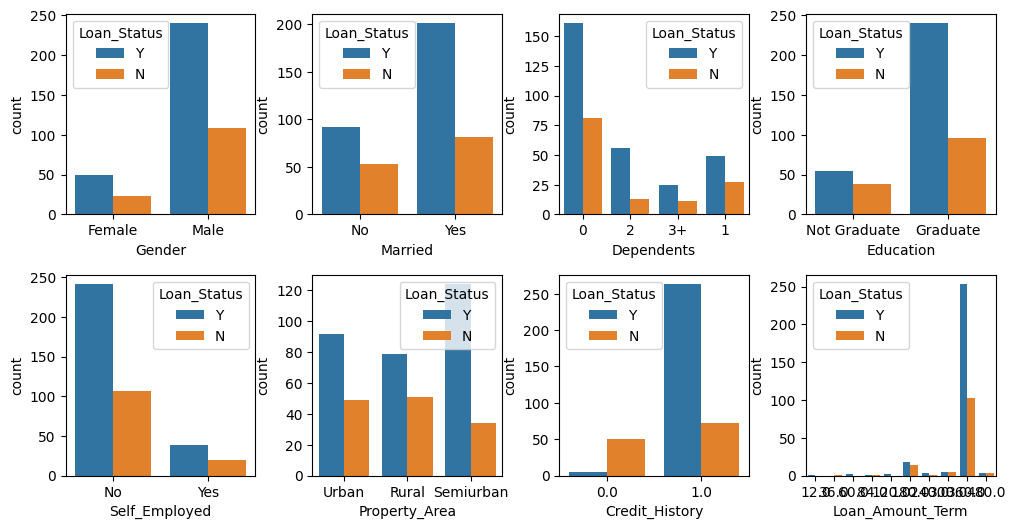

In [96]:
fig,axes = plt.subplots(2,4,figsize=(12, 6))
for idx,cat_col in enumerate(categorical_columns):
    row, col = idx//4, idx%4
    sns.countplot(x=cat_col,data=data_train,hue='Loan_Status', hue_order=['Y', 'N'], ax=axes[row,col])

plt.subplots_adjust(hspace=0.3, wspace=0.3)

### Numerical Feature Analysis

Statistical summaries of the numerical features reveal that the maximum values for ApplicantIncome and CoapplicantIncome are roughly 15 times greater than their respective 75th percentiles. This suggests that these maximum values represent annual income, whereas the majority of records reflect monthly income.

In [97]:
# Summary statistics for numerical columns
print("Summary Statistics for Numerical Variables")
print("-" * 50)
print(data_train[numerical_columns].describe())

Summary Statistics for Numerical Variables
--------------------------------------------------
       ApplicantIncome  CoapplicantIncome  LoanAmount
count       429.000000         429.000000  413.000000
mean       5623.212121        1588.776224  149.239709
std        6763.466739        2787.711907   90.101632
min         210.000000           0.000000    9.000000
25%        2917.000000           0.000000  100.000000
50%        3902.000000        1086.000000  128.000000
75%        5821.000000        2250.000000  172.000000
max       81000.000000       41667.000000  700.000000


Box plots help visualize the outliers in `ApplicantIncome` and `CoapplicantIncome`. We will address these outliers during the data preprocessing step.

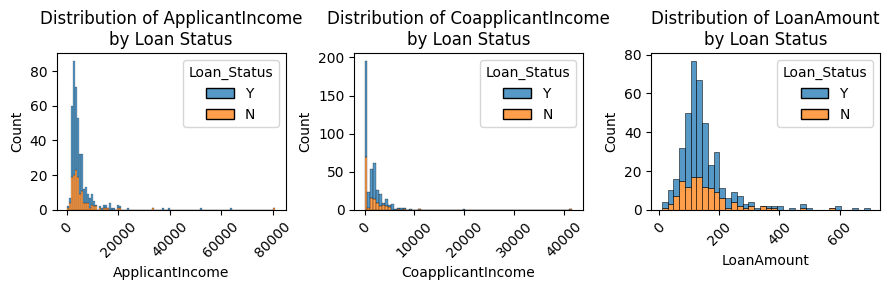

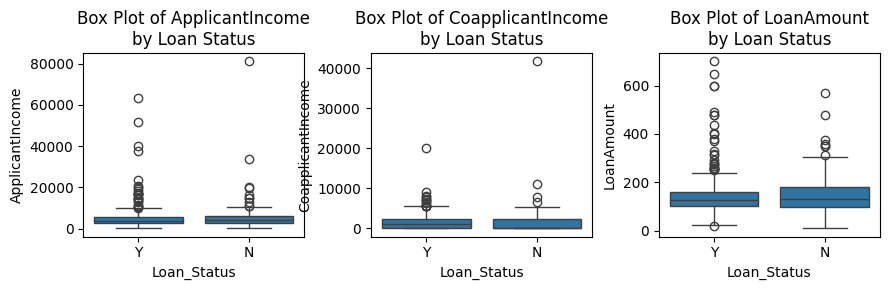

In [98]:
# Distribution plots for numerical variables of training data
plt.figure(figsize=(9, 3))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=data_train, x=col, hue='Loan_Status', multiple="stack")
    plt.title(f'Distribution of {col}\nby Loan Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

# Box plots for numerical variables
plt.figure(figsize=(9, 3))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=data_train, y=col, x='Loan_Status')
    plt.title(f'Box Plot of {col}\nby Loan Status')
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

In [99]:
# Convert Loan_Status to numerical values
data_train['Loan_Status'] = data_train['Loan_Status'].map({'Y': 1, 'N': 0})
data_test['Loan_Status'] = data_test['Loan_Status'].map({'Y': 1, 'N': 0})

### Statistical Testing
To validate feature importance:
- Chi-square tests can be applied to categorical features.
- T-tests can be performed on numerical variables.

In [100]:
# Statistical tests
print("Statistical Tests")
print("-" * 50)

# Chi-square test for categorical variables
from scipy.stats import chi2_contingency
print("\nChi-square test results:")
for col in categorical_columns:
    contingency_table = pd.crosstab(data_train[col], data_train['Loan_Status'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print(f"{col}: p-value = {p_value:.4f}")

# T-test for numerical variables
from scipy.stats import ttest_ind
print("\nT-test results:")
for col in numerical_columns:
    t_stat, p_value = ttest_ind(
        data_train[data_train['Loan_Status'] == 1][col],
        data_train[data_train['Loan_Status'] == 0][col]
    )
    print(f"{col}: p-value = {p_value:.4f}")

Statistical Tests
--------------------------------------------------

Chi-square test results:
Gender: p-value = 0.9904
Married: p-value = 0.1234
Dependents: p-value = 0.1040
Education: p-value = 0.0326
Self_Employed: p-value = 0.6780
Property_Area: p-value = 0.0030
Credit_History: p-value = 0.0000
Loan_Amount_Term: p-value = 0.2594

T-test results:
ApplicantIncome: p-value = 0.7812
CoapplicantIncome: p-value = 0.5451
LoanAmount: p-value = nan


**Key Insights for Model Building**

- Credit_History should be a key feature in the model
- Property_Area, Married status, and Education level are important predictors
- Gender, Self_Employed status, and number of Dependents could potentially be dropped
- Income variables alone might not be good predictors - consider creating derived features or interactions

These results suggest focusing on Credit_History, Property_Area, Married status, and Education level as primary features for the initial model.

### Correlation Analysis

The target variable `Loan_Status` is converted from Yes/No to 1/0. Initial correlation analysis of numerical features reveals:
- A strong correlation between `ApplicantIncome` and `LoanAmount`, which is expected.
- A strong correlation between `Loan_Status` and `Credit_History`, as we already found out during Categorical Features Analysis.
- No significant correlation between `Loan_Status` and income or loan variables.

Further correlation analysis will be conducted after Feature Engineering to assess relationships post-transformation.

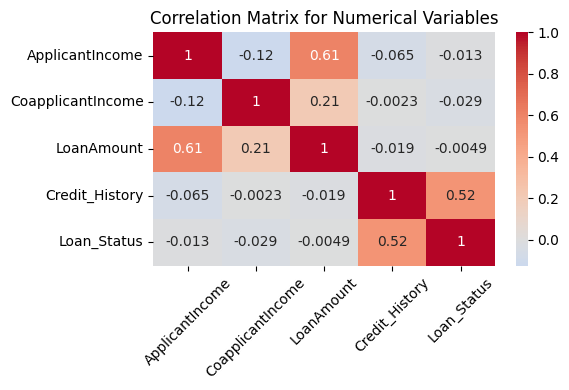

In [101]:
# Correlation analysis for numerical variables
plt.figure(figsize=(6, 4))
sns.heatmap(data_train[numerical_columns + ['Credit_History'] + ['Loan_Status']].corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title('Correlation Matrix for Numerical Variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

Before preprocessing steps like filling in missing values or scaling, make sure we have split the dataset into training and testing sets. This prevents "cheating", where test data inadvertently influences the training process.

All preprocessing steps, such as imputing or scaling, should be fitted on the training data and then applied to the test data using the same settings. Always be cautious to avoid letting unseen data from the test set influence the preprocessing!

**Checking for Duplicates**

No duplicate records are found in this dataset, so no further action is required.

In [102]:
# Check for duplicates
duplicates = data[data.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")

Number of duplicate rows: 0


### Handling Missing Values

In [103]:
data_null_counts = data.isnull().sum()

print("Null values in data:\n", data_null_counts)

Null values in data:
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [104]:
# Count the number of rows with at least one null value
print(f"Number of rows with at least one null value: {data.isnull().any(axis=1).sum()}")

Number of rows with at least one null value: 134


The dataset contains 134 rows with at least one missing value, which is significant given the total of 641 rows. Instead of dropping these rows, we will impute the missing values to retain as much data as possible:

- Numerical Columns: Imputed using the mean or median values.
- Categorical Columns: Imputed using the mode (most frequent value).

In [105]:
# Impute missing categorical value by Most frequent value (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')
data_train[['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']] = \
    cat_imputer.fit_transform(data_train[['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']])
data_test[['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']] = \
    cat_imputer.transform(data_test[['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']])

num_imputer_mean = SimpleImputer(strategy='mean')
data_train[['LoanAmount']] = num_imputer_mean.fit_transform(data_train[['LoanAmount']])
data_test[['LoanAmount']] = num_imputer_mean.transform(data_test[['LoanAmount']])

An experiment that we can do here is to impute missing credit history values using a classification model (e.g., Random Forest or XGBoost). Since credit history often has relationships with income, employment status, marital status and education, the model can predict missing values of credit history based on these fields.

### Handling Outliers

Outliers can mess up how well a model performs, so it's important to handle them. From the analysis in the Numerical Features section, I'm pretty sure ApplicantIncome and CoapplicantIncome represent monthly income since the 75th percentile is $5795. But there are a few cases where income is over \$20,000, which looks more like annual income.

To deal with this, there are two options among others: either remove those outliers or cap the values at $20,000. In this case, I assumed the higher numbers were annual incomes, so I adjusted them by dividing by 12 to turn them into monthly figures.

In [106]:
data_train.loc[data_train['ApplicantIncome'] >= 20000, 'ApplicantIncome'] /= 12
data_train.loc[data_train['CoapplicantIncome'] >= 20000, 'CoapplicantIncome'] /= 12

data_test.loc[data_test['ApplicantIncome'] >= 20000, 'ApplicantIncome'] /= 12
data_test.loc[data_test['CoapplicantIncome'] >= 20000, 'CoapplicantIncome'] /= 12

### Encoding Categorical Variables

Instead of using one-hot or label encoding, categorical features were manually mapped to numeric values while keeping the same feature names. This approach retains interpretability and keeps the dataset's dimensionality manageable.

- For example, the `Property_Area` feature was encoded as follows: Rural = 0, Semiurban = 1, Urban = 2

This method works well as most categorical features in the dataset have only 2-3 unique values, making manual encoding straightforward and preserving any ordinal relationships.

In [107]:
def encode_categorical_features(data):
  data['Self_Employed']   = data['Self_Employed'].map({'Yes':1, 'No':0})
  data['Gender']          = data['Gender'].map({'Male':1, 'Female':0})
  data['Dependents']      = data['Dependents'].replace('3+', '3').astype(int) # Replace "3+" with "3" and convert the data type to int
  data['Married']         = data['Married'].map({'Yes':1, 'No':0})
  data['Education']       = data['Education'].map({'Graduate':1, 'Not Graduate':0})
  data['Property_Area']   = data['Property_Area'].map({'Urban':2, 'Semiurban':1, 'Rural':0})

  # Convert the data type from float to int
  data['Credit_History']  = data['Credit_History'].astype(int)
  return data

data_train = encode_categorical_features(data_train)
data_test = encode_categorical_features(data_test)

In [108]:
data_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
197,0,0,0,0,0,1907.0,2365.0,120.0,360.0,1,2,1
175,1,1,0,1,0,3497.0,1964.0,116.0,360.0,1,0,1
526,1,1,0,1,0,3775.0,0.0,110.0,360.0,1,1,1
149,1,1,0,1,0,4860.0,830.0,125.0,360.0,1,1,1
507,1,0,0,1,0,3583.0,0.0,96.0,360.0,1,2,0


### Feature Engineering

Feature engineering plays a crucial role in improving model performance.

**Interaction Terms**

The dataset includes `ApplicantIncome`, `CoapplicantIncome`, which are great for understanding an applicant's financial situation. But we can take it a step further by creating new features that give more insight:
- **Total Income**: This combines both incomes and can help predict loan approval since higher income usually means better repayment ability.
- **Income Loan Ratio**: This shows how well the applicant's total income can cover the loan amount. There aren't any missing or zero values in the LoanAmount feature, so this calculation is clean. A higher `Income Loan Ratio` increases the likelihood of loan approval.
- **Balance Income**: This tells us how much income is left after paying the monthly loan payment. It uses the `Loan_Amount_Term` feature, which also doesn't have missing or zero values. A higher `Balance Income` also increases the likelihood of loan approval.

In [109]:
def create_new_features(data):
  data['Total_Income'] = data['ApplicantIncome'] + data['CoapplicantIncome']
  data['Income_Loan_Ratio'] = data['Total_Income'] / data['LoanAmount']
  data['EMI'] = data['LoanAmount'] * 1000 / data['Loan_Amount_Term']
  data['Balance_Income'] = data['Total_Income'] - data['EMI']

  data['Balance_Income'] = data['Balance_Income'].astype(int)
  data['EMI'] = data['EMI'].astype(float)
  data['Loan_Amount_Term'] = data['Loan_Amount_Term'].astype(int)
  return data

data_train = create_new_features(data_train)
data_test = create_new_features(data_test)

data_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Income_Loan_Ratio,EMI,Balance_Income
197,0,0,0,0,0,1907.0,2365.0,120.0,360,1,2,1,4272.0,35.600000,333.333333,3938
175,1,1,0,1,0,3497.0,1964.0,116.0,360,1,0,1,5461.0,47.077586,322.222222,5138
526,1,1,0,1,0,3775.0,0.0,110.0,360,1,1,1,3775.0,34.318182,305.555556,3469
149,1,1,0,1,0,4860.0,830.0,125.0,360,1,1,1,5690.0,45.520000,347.222222,5342
507,1,0,0,1,0,3583.0,0.0,96.0,360,1,2,0,3583.0,37.322917,266.666667,3316


I was hoping these new features would add more depth to the data and help our models make better predictions. But let's see if my assumption - that higher values mean a better chance of loan approval - actually holds. The overall Loan Status distribution in the dataset is 31% Rejected (No) and 69% Approved (Yes). So, I took the top 36 applications with the highest Income_Loan_Ratio, Total_Income, and Balance_Income to compare their approval rates.

In [110]:
# Analyze loan approval distribution for a given numerical column within specified range
def analyze_loan_distribution(df, column_name, min_value=None, max_value=None):
    condition = True
    filter_description = []

    if min_value is not None:
        condition &= (df[column_name] >= min_value)
        filter_description.append(f">= {min_value}")

    if max_value is not None:
        condition &= (df[column_name] <= max_value)
        filter_description.append(f"<= {max_value}")

    filtered_df = df[condition]
    status_counts = filtered_df['Loan_Status'].value_counts()

    filter_text = f"{column_name} " + " and ".join(filter_description)
    print(f"Loan Status distribution for {filter_text}:")
    print(f"  Rejected (0): {status_counts.get(0, 0)}")
    print(f"  Approved (1): {status_counts.get(1, 0)}")

In [111]:
analyze_loan_distribution(data_train, 'Income_Loan_Ratio', 75, None)
analyze_loan_distribution(data_train, 'Total_Income', 11000, None)
analyze_loan_distribution(data_train, 'Balance_Income', 10600, None)

analyze_loan_distribution(data_train, "Balance_Income", None, max_value=0)

Loan Status distribution for Income_Loan_Ratio >= 75:
  Rejected (0): 9
  Approved (1): 27
Loan Status distribution for Total_Income >= 11000:
  Rejected (0): 11
  Approved (1): 25
Loan Status distribution for Balance_Income >= 10600:
  Rejected (0): 11
  Approved (1): 25
Loan Status distribution for Balance_Income <= 0:
  Rejected (0): 1
  Approved (1): 2


The results were surprising. The approval rates for the top `Total_Income` and `Balance_Income` applications weren't any different from the rest. For applicants with high total income, it makes sense-they probably applied for larger loans and got rejected. But I couldn't figure out why those with high balance income were rejected, or why two applicants with a balance income ≤ 0 were approved. It seems like the dataset doesn't really support `Total_Income` and `Balance_Income` as useful features. So, I'm thinking of dropping them and keeping `Income_Loan_Ratio` instead.

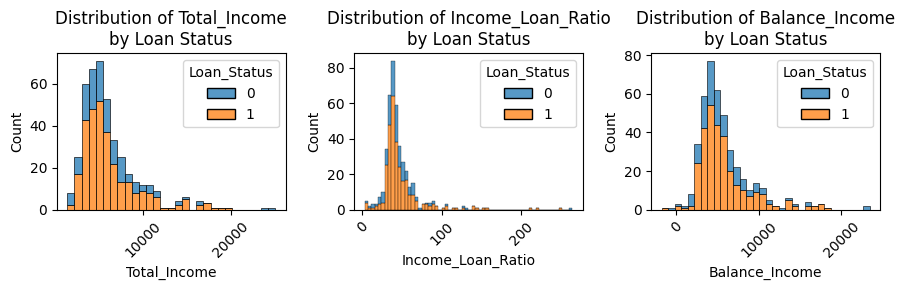

In [112]:
# Distribution plots for numerical variables
plt.figure(figsize=(9, 3))
for i, col in enumerate(['Total_Income', 'Income_Loan_Ratio', 'Balance_Income'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=data_train, x=col, hue='Loan_Status', multiple="stack")
    plt.title(f'Distribution of {col}\nby Loan Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

**Correlation Insights**

After converting all features to numeric, we check the correlation map again:
- Strong correlation between Loan_Status and Credit_History.
- Graduate people tends to have better income.
- There are some highly correlated features: ApplicantIncome with Total_Income, Balance_Income, LoanAmount or Income_Loan_Ratio with Balance_Income, Total_Income, ApplicantIncome.

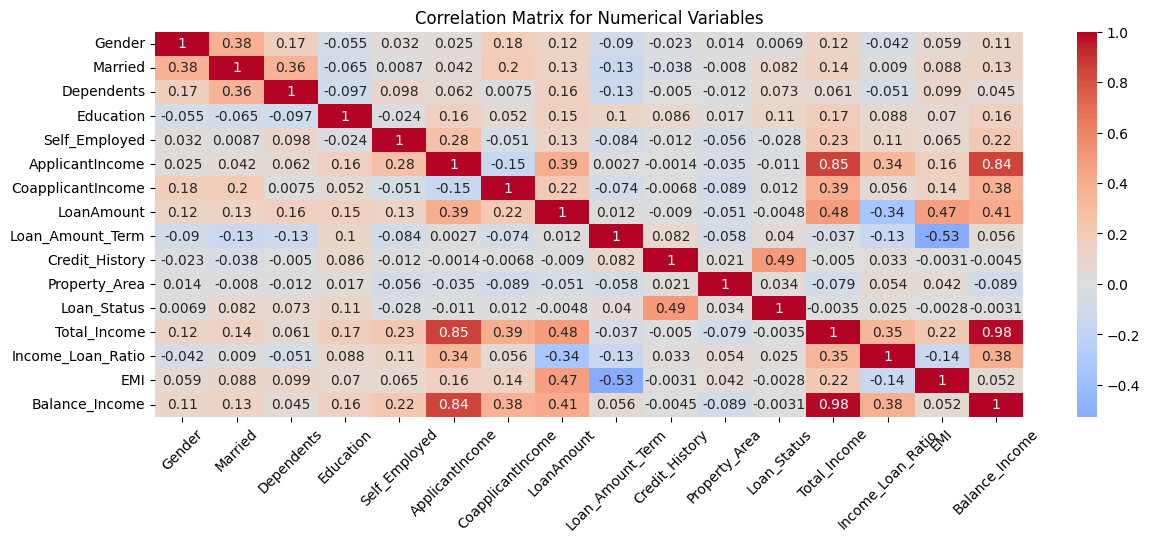

In [113]:
#Checking for correlation
plt.figure(figsize=(14, 5))
sns.heatmap(data_train.corr(),cmap='coolwarm', center=0,annot=True)
plt.title('Correlation Matrix for Numerical Variables')
plt.xticks(rotation=45)
plt.show()

A correlation matrix is great for spotting linear relationships between features. It's especially useful for catching multicollinearity, which can be an issue for models like Logistic Regression. It also helps with feature selection—by removing highly correlated features, we can avoid redundancy.

Looking at the income-related features (ApplicantIncome, CoapplicantIncome, EMI, Total_Income, Balance_Income, Income_Loan_Ratio), I decided to keep Income_Loan_Ratio. It combines the meaning of income and loan and seems to align well with Loan_Status.

That said, I want to be sure dropping the other features won’t hurt the model’s performance. To test this, I created a compare_performance() function that uses cross_validate to run five base models and compare their F1 scores before and after removing those features.

**Utilities**

In [114]:
from datetime import datetime
import os
import pytz

est = pytz.timezone('US/Eastern')

class ExperimentLogger:
    def __init__(self):
        self.experiments = []

    def log_experiment(self, experiment, model_name, score_before, score_after, features_before, features_after, duration):
        """
        Log a single experiment
        """
        experiment = {
            'timestamp': datetime.now(est).strftime('%m-%d %H:%M:%S'),  # %Y-
            'experiment': experiment,
            'model_name': model_name,
            'score_before': round(score_before, 3) if score_before is not None else 0,
            'score_after': round(score_after, 3),
            'improvement': round(score_after - score_before, 3) if score_before is not None else 0,
            'features_before': features_before.columns.tolist() if features_before is not None else "",
            'features_after': features_after.columns.tolist(),
            'duration': round(duration, 4) if duration is not None else ""
        }
        self.experiments.append(experiment)

    def save_results(self, filename):
        """
        Save experiments to CSV
        """
        df = pd.DataFrame(self.experiments)
        file_path = f"{filename}_{datetime.now(est).strftime('%Y-%m-%d')}.csv"
        if os.path.exists(file_path):
          # Append without header
          df.to_csv(file_path, mode='a', index=False, header=False)
        else:
          # Create new file with header
          df.to_csv(file_path, index=False)

In [115]:
logger = ExperimentLogger()

In [116]:
def compare_performance(experiment, X_before, y_before, X_after, y_after):
    models = [
      LogisticRegression(random_state=RND),
      DecisionTreeClassifier(random_state=RND),
      RandomForestClassifier(random_state=RND),
      MLPClassifier(random_state=RND, max_iter=100),
      XGBClassifier(random_state=RND),
    ]

    for model in models:
      # Cross-validation scores before feature engineering
      scores_before = cross_val_score(model, X_before, y_before, scoring='f1', cv=5)
      mean_score_before = round(scores_before.mean(), 3)

      # Cross-validation scores after feature engineering
      scores_after = cross_val_score(model, X_after, y_after, scoring='f1', cv=5)
      mean_score_after = round(scores_after.mean(), 3)
      improvement = round(mean_score_after - mean_score_before, 3)

      # Log the experiment
      logger.log_experiment(
          experiment,
          model.__class__.__name__,
          mean_score_before,
          mean_score_after,
          features_before=X_before,
          features_after=X_after,
          duration=None)
      print(f"{model.__class__.__name__}: {mean_score_before}, {mean_score_after} " \
            f"--> (improvement) {improvement}")

**Drop features that are highly correlated**

If the new features capture unique patterns or relationships with the target variable (e.g., Income_Loan_Ratio might better relate to Loan_Status than ApplicantIncome alone), they can improve the model's predictive power.

In [117]:
X_before = data_train.drop(columns=['Loan_Status'])
y_before = data_train['Loan_Status']

drop_columns = ['ApplicantIncome', 'CoapplicantIncome', 'EMI', 'Total_Income', 'Balance_Income']
data_train.drop(columns=drop_columns, inplace=True)
data_test.drop(columns=drop_columns, inplace=True)

X_after = data_train.drop(columns=['Loan_Status'])
y_after = data_train['Loan_Status']

print(f"Features BEFORE: {X_before.columns.tolist()}")
print(f"Features AFTER: {X_after.columns.tolist()}\n")
compare_performance('Drop Correlated', X_before, y_before, X_after, y_after)

Features BEFORE: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Total_Income', 'Income_Loan_Ratio', 'EMI', 'Balance_Income']
Features AFTER: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Income_Loan_Ratio']

LogisticRegression: 0.828, 0.862 --> (improvement) 0.034
DecisionTreeClassifier: 0.764, 0.758 --> (improvement) -0.006
RandomForestClassifier: 0.832, 0.849 --> (improvement) 0.017
MLPClassifier: 0.591, 0.795 --> (improvement) 0.204
XGBClassifier: 0.816, 0.814 --> (improvement) -0.002


After drop highly correlated Features 'ApplicantIncome', 'CoapplicantIncome', 'EMI', 'Total_Income', 'Balance_Income', the model performances remain relatively unchanged with the exception of MLPClassifier model which improved significantly from 0.59 to 0.80.

### Assessing Feature Importance

Feature importance helps us figure out which features actually matter for the model's predictions. By focusing on the most relevant ones, we can cut down on noise, boost accuracy, and make the model perform better overall and easier to understand. And fewer features mean faster training and prediction times.

I'm using a Random Forest to calculate feature importance. It ranks features based on how much they help reduce impurity (like Gini index or entropy) during training.

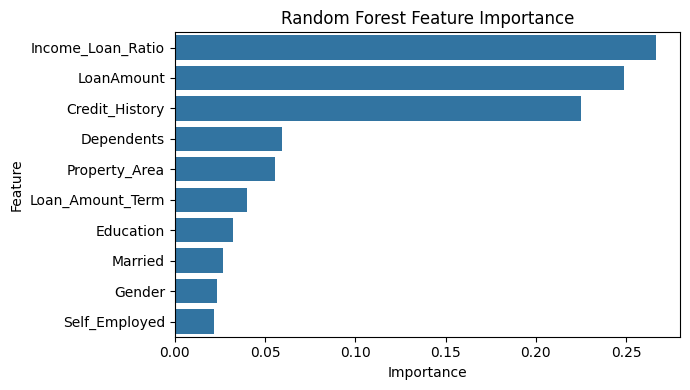

In [118]:
X = data_train.drop(columns=['Loan_Status'])
y = data_train['Loan_Status']

rf_model = RandomForestClassifier(n_estimators=100, random_state=RND)
rf_model.fit(X, y)

# Get feature importance
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})
feature_imp = feature_imp.sort_values('Importance', ascending=False)

# Plot Random Forest Feature Importance
plt.figure(figsize=(7, 4))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10))
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

We can see that Credit_History, Income_Loan_Ratio and LoanAmount are significantly more important than the rest of features.

### Feature Selection

Drop less important features 'Self_Employed', 'Gender', 'Married', 'Education', 'Loan_Amount_Term', 'Property_Area', 'Dependents'.

Compare performance before and after the removal to ensure no loss in predictive power.

In [119]:
X_before = data_train.drop(columns=['Loan_Status'])
y_before = data_train['Loan_Status']

drop_columns = ['Self_Employed', 'Gender', 'Married', 'Education', 'Loan_Amount_Term', 'Property_Area', 'Dependents']
data_train.drop(columns=drop_columns, inplace=True)
data_test.drop(columns=drop_columns, inplace=True)

X_after = data_train.drop(columns=['Loan_Status'])
y_after = data_train['Loan_Status']

print(f"Features BEFORE: {X_before.columns.tolist()}")
print(f"Features AFTER: {X_after.columns.tolist()}\n")
compare_performance('Drop Unimportance', X_before, y_before, X_after, y_after)


Features BEFORE: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Income_Loan_Ratio']
Features AFTER: ['LoanAmount', 'Credit_History', 'Income_Loan_Ratio']

LogisticRegression: 0.862, 0.867 --> (improvement) 0.005
DecisionTreeClassifier: 0.758, 0.764 --> (improvement) 0.006
RandomForestClassifier: 0.849, 0.811 --> (improvement) -0.038
MLPClassifier: 0.795, 0.815 --> (improvement) 0.02
XGBClassifier: 0.814, 0.816 --> (improvement) 0.002


In [120]:
data_train.head(3)

,LoanAmount,Credit_History,Loan_Status,Income_Loan_Ratio
197,120.0,1,1,35.600000
175,116.0,1,1,47.077586
526,110.0,1,1,34.318182


Surprisingly, with just those 3 features, the performance of all 5 models are quite the same with 10 features, which means 7 features do not contribute much to the prediction ability.

### Reduce Skewness in Data

Many ML algorithms, such as linear regression, neural networks, and KNN, perform better with normally distributed data. I used log1p() to reduce skewness and transform positively skewed data (where the tail is on the right) into a more balanced distribution.

In the figure below, you can see the skewness of the LoanAmount and Income_Loan_Ratio data on the left and the more balanced distribution after skewness reduction on the right.

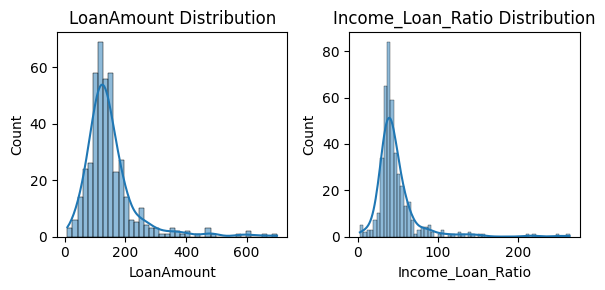

In [121]:
plt.figure(figsize=(6, 3))
for i, col in enumerate(['LoanAmount', 'Income_Loan_Ratio'], 1):
    plt.subplot(1, 2, i)
    sns.histplot(data_train[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

In [122]:
## Reducing skewness
for col in ['LoanAmount', 'Income_Loan_Ratio']:
    data_train[col] = np.log1p(data_train[col])
    data_test[col] = np.log1p(data_test[col])

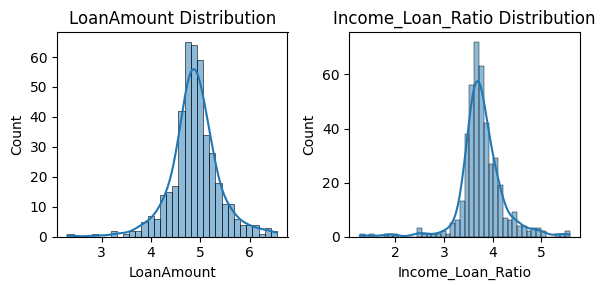

In [123]:
plt.figure(figsize=(6, 3))
for i, col in enumerate(['LoanAmount', 'Income_Loan_Ratio'], 1):
    plt.subplot(1, 2, i)
    sns.histplot(data_train[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

### Scaling Data

After reducing skewness, the values for LoanAmount are mostly around 5, and for Income_Loan_Ratio, they're around 4. The difference between 4 and 5 is not much but let's go ahead and do the feature scaling. Some machine learning algorithms (like Logistic Regression, SVM, k-NN, or neural networks) are sensitive to the scale of the features. Features with larger values can dominate smaller ones if they're not scaled.

LoanAmount and Income_Loan_Ratio are not bounded data so we will apply StandardScaler with zero mean and unit variance, the data distribution shape is preserved.

In [124]:
scaler = StandardScaler()
data_train[['LoanAmount', 'Income_Loan_Ratio']] = scaler.fit_transform(data_train[['LoanAmount', 'Income_Loan_Ratio']])  # , 'Credit_History'
data_test[['LoanAmount', 'Income_Loan_Ratio']] = scaler.transform(data_test[['LoanAmount', 'Income_Loan_Ratio']])

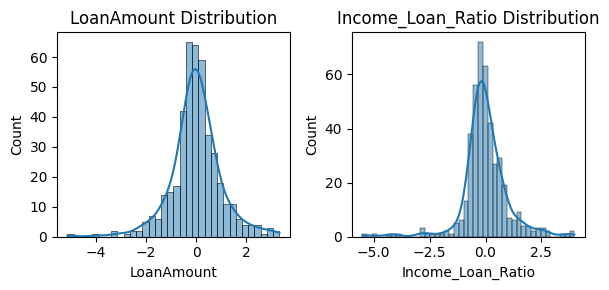

In [125]:
plt.figure(figsize=(9, 3))
for i, col in enumerate(['LoanAmount', 'Income_Loan_Ratio'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(data_train[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

**The Final Dataset**

After all the preprocessing, the final dataset is ready! It includes two original features (LoanAmount and Credit_History) and one new interaction feature (Income_Loan_Ratio). With that, we're all set to move on to the modeling phase!

In [126]:
order = ['Credit_History', 'LoanAmount', 'Income_Loan_Ratio', 'Loan_Status']
data_train = data_train[order]
data_test = data_test[order]
data_train.iloc[16:20]

,Credit_History,LoanAmount,Income_Loan_Ratio,Loan_Status
26,1,-0.141848,-0.060960,1
404,1,0.772388,-0.225573,0
265,1,0.278147,0.342984,1
471,0,-0.292601,-0.317186,0


**Handling class imbalance**:

We'll explore this in an experiment later on.


**Iterative Process**

Data preprocessing is not straight forward, it is an iterative process. It involves adding or removing features, adjusting data, evaluating model performance, and come back refining the dataset again and again until the best feature set for prediction is identified. I tried using Chi-square and T-tests to validate feature importance, but they didn't really help much with improving predictions. So, I skipped over those and went with the Feature Importance method instead - it turned out to be a better fit for this task.

## 4. Model Development (on TEST data)

In [127]:
X_train = data_train.drop(columns=['Loan_Status'])
y_train = data_train['Loan_Status']
X_test = data_test.drop(columns=['Loan_Status'])
y_test = data_test['Loan_Status']

**Establishing Baseline with Decision Tree**

I started with a simple Decision Tree model to establish baseline performance. As expected, it performed perfectly on the training data with an F1 score of 100%. However, this wasn't surprising—by default, DecisionTreeClassifier doesn't limit the depth or complexity of the tree, so it grows deep enough to memorize the training data. The downside is it didn't generalize well to the unseen test data, leading to a much lower F1 score on the test set.

### Decision Tree

In [128]:
start_time_grid = time.time()
# Create and train the decision tree model
clf = DecisionTreeClassifier(random_state=RND)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
f1_train = f1_score(y_train, y_pred)
print(f"DecisionTreeClassifier - Training Set F1 Score: {f1_train:.4f}")

train_time = time.time() - start_time_grid

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)

print(f"DecisionTreeClassifier - Test Set F1 Score: {f1_test:.4f}")

# Log the experiment
logger.log_experiment(
    experiment='Model Selection',
    model_name="DecisionTreeClassifier",
    score_before=None,
    score_after=f1,
    features_before=None,
    features_after=X_train,
    duration=train_time)

DecisionTreeClassifier - Training Set F1 Score: 1.0000
DecisionTreeClassifier - Test Set F1 Score: 0.7434


### Hyperparameter Tuning
1. GridSearchCV

With only 429 records in the training dataset, the model easily overfits. To tackle this, I moved beyond the default parameters and used GridSearchCV for hyperparameter tuning. This method systematically tests different combinations of settings to find the best configuration for the dataset.

I focused on reducing overfitting by limiting the depth of the tree and using parameters like min_samples_split and min_samples_leaf. These settings prevent the model from focusing too much on small, specific subsets of the data. By optimizing these hyperparameters, I improved the model's ability to generalize and achieve better test performance, particularly in terms of the F1 score across cross-validation folds.

In [129]:
# Create Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=RND)

# Define parameter grid
param_grid = {
    'max_depth': list(range(2, 6)),           # 4 values
    'min_samples_split': range(2, 21),        # 19 values
    'min_samples_leaf': range(6, 25),         # 19 values
    'criterion': ['gini', 'entropy']          # 2 values
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,         # 5-fold cross-validation
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

In [130]:
def grid_search_dt(X_train, y_train, X_test, y_test):
  start_time_grid = time.time()
  # Fit the model
  grid_search.fit(X_train, y_train)
  end_time_grid = time.time()

  optim_time = end_time_grid - start_time_grid
  print(f"GridSearchCV took {optim_time:.2f} seconds")
  # Print best parameters and score from cross-validation
  print("Best parameters:", grid_search.best_params_)
  print("Best cross-validation score:", grid_search.best_score_)

  # Get the best model
  best_model = grid_search.best_estimator_

  # Make predictions on test set
  y_pred = best_model.predict(X_test)

  # Calculate accuracy and f1 score
  f1 = f1_score(y_test, y_pred, average='weighted')

  print("\nDecision Tree Grid - Test Set Performance:")
  print(f"  Accuracy Score: {accuracy:.4f}")
  print(f"  F1 Score: {f1:.4f}")

  # Log the experiment
  logger.log_experiment(
      experiment='Model Selection',
      model_name="Decision Tree Grid",
      score_before=None,
      score_after=f1,
      features_before=None,
      features_after=X_train,
      duration=optim_time)

In [131]:
grid_search_dt(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 2888 candidates, totalling 14440 fits
GridSearchCV took 17.00 seconds
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best cross-validation score: 0.8637208446290853

Decision Tree Grid - Test Set Performance:
  Accuracy Score: 0.6865
  F1 Score: 0.8448


2. RandomSearchCV

In [132]:
from scipy.stats import randint, uniform, loguniform

# Define the parameter distribution for random search
dt_param_dist = {
    'max_depth': randint(2, 6),             # 4 values
    'min_samples_split': randint(2, 21),    # 19 values
    'min_samples_leaf': randint(6, 25),     # 19 values
    'criterion': ['gini', 'entropy']        # 2 values
}

# Create Decision Tree classifier
dt = DecisionTreeClassifier(random_state=RND)

# Create RandomizedSearchCV object
dt_random = RandomizedSearchCV(
    estimator=dt,
    param_distributions=dt_param_dist,
    n_iter=n_iter,            # Number of parameter settings sampled
    cv=5,                     # 5-fold cross-validation
    scoring='f1',             # Metric to optimize
    random_state=RND,
    n_jobs=-1,                # Use all available cores
    verbose=2
)

In [133]:
def dt_random_search(X_train, y_train, X_test, y_test):
  start_time_grid = time.time()
  # Fit the random search
  dt_random.fit(X_train, y_train)
  end_time_grid = time.time()

  optim_time = end_time_grid - start_time_grid
  print(f"DecisionTree optimization using RandomizeSearchCV took {optim_time:.2f} seconds")
  # Print results
  print("Best parameters:", dt_random.best_params_)
  print("Best cross-validation score:", dt_random.best_score_)

  # Print top 5 parameter combinations
  results = pd.DataFrame(dt_random.cv_results_)
  results_sorted = results.sort_values('rank_test_score')
  print("\nTop 5 parameter combinations:")
  print(results_sorted[['params', 'mean_test_score']].head(5))

  # Use best model to predict
  best_model = dt_random.best_estimator_
  y_dt_pred = best_model.predict(X_test)
  y_dt_proba = best_model.predict_proba(X_test)

  # Calculate accuracy and f1 score
  accuracy = accuracy_score(y_test, y_dt_pred)
  f1 = f1_score(y_test, y_dt_pred, average='weighted')

  print("\nDecision Tree Randomize - Test Set Performance:")
  print(f"  Accuracy: {accuracy:.4f}")
  print(f"  F1 Score: {f1:.4f}")

  # Log the experiment
  logger.log_experiment(
      experiment='Model Selection',
      model_name="Decision Tree Randomize",
      score_before=None,
      score_after=f1,
      features_before=None,
      features_after=X_train,
      duration=optim_time)
  return y_dt_pred, y_dt_proba

In [134]:
y_dt_pred, y_dt_proba = dt_random_search(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
DecisionTree optimization using RandomizeSearchCV took 0.15 seconds
Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 12, 'min_samples_split': 20}
Best cross-validation score: 0.8610762103465991

Top 5 parameter combinations:
                                               params  mean_test_score
1   {'criterion': 'entropy', 'max_depth': 2, 'min_...         0.861076
12  {'criterion': 'entropy', 'max_depth': 2, 'min_...         0.861076
17  {'criterion': 'entropy', 'max_depth': 3, 'min_...         0.858286
7   {'criterion': 'gini', 'max_depth': 4, 'min_sam...         0.857132
10  {'criterion': 'gini', 'max_depth': 4, 'min_sam...         0.857132

Decision Tree Randomize - Test Set Performance:
  Accuracy: 0.8865
  F1 Score: 0.8821


For this simple dataset, I set the number of parameter settings sampled to 20 (compared to 2,888 combinations with GridSearchCV). RandomizedSearchCV took only 0.89 seconds (vs. 117 seconds for GridSearchCV) to find the best parameter settings (model) with the highest cross-validation score. Interestingly, the best model achieved an F1 score of 0.88 on the test set, which is even higher than the 0.84 F1 score of the model found by GridSearchCV.

- Same cross-validation score: 0.861. Many combinations have the same score. GridSearchCV and RandomizedSearchCV may pick different combos hence achieve different test performance.

Given its speed and comparable test performance, I've chosen RandomizedSearchCV as the hyperparameter tuning method for the next models.

Accuracy/Performance:
- GridSearchCV generally finds slightly better parameters because it tests ALL combinations
- RandomizedSearchCV might miss the absolute best combination but often finds very close solutions
- The difference in final performance is usually small for well-defined parameter spaces

Time Efficiency:
- GridSearchCV is much slower because it tests every combination
- RandomizedSearchCV is significantly faster because it tests only n_iter combinations

When to Use Each:
- Use GridSearchCV when:
  - You have limited parameter options
  - Computation time isn't a constraint
  - You need the absolute best combination

- Use RandomizedSearchCV when:
  - You have large parameter spaces
  - Time/resources are limited
  - A "good enough" solution is acceptable

### Comparison of other Classification Models
1. Random Forest

In [135]:
# 4. Random Forest
# Define the parameter space for RandomizedSearchCV
rf_param_dist = {
    'n_estimators': np.arange(50, 250, 50),      # Number of trees 1000
    'max_depth': np.arange(10, 15),              # Max depth of trees 2, 20
    'min_samples_split': np.arange(3, 8, 2),     # Min samples to split node
    'min_samples_leaf': np.arange(10, 20, 2),    # Min samples in leaf node 3
}

# Initialize the base model
rf = RandomForestClassifier(random_state=RND)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf, param_distributions=rf_param_dist, n_iter=n_iter,
    cv=5, scoring='f1', n_jobs=-1, verbose=2, random_state=RND
)

In [136]:
def rf_random_search(X_train, y_train, X_test, y_test):
  start_time = time.time()
  # Fit RandomizedSearchCV
  rf_random.fit(X_train, y_train)

  optim_time = time.time() - start_time
  print(f"\nRF optimization took {optim_time:.2f} seconds")
  print("Best RF parameters:", rf_random.best_params_)
  print("Best RF score:", rf_random.best_score_)

  rf_best = rf_random.best_estimator_
  y_rf_pred = rf_best.predict(X_test)
  y_rf_proba = rf_best.predict_proba(X_test)
  rf_accuracy = accuracy_score(y_test, y_rf_pred)
  rf_f1 = f1_score(y_test, y_rf_pred)

  print("\nRF Test Set Performance:")
  print(f"  Accuracy: {rf_accuracy:.4f}")
  print(f"  F1 Score: {rf_f1:.4f}")

  # Log the experiment
  logger.log_experiment(
      experiment='Model Selection',
      model_name = "RandomForestClassifier",
      score_before=None,
      score_after=rf_f1,
      features_before=None,
      features_after=X_train,
      duration=optim_time)

  return y_rf_pred, y_rf_proba

In [137]:
y_rf_pred, y_rf_proba = rf_random_search(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

RF optimization took 3.11 seconds
Best RF parameters: {'n_estimators': np.int64(100), 'min_samples_split': np.int64(5), 'min_samples_leaf': np.int64(18), 'max_depth': np.int64(13)}
Best RF score: 0.8670971766554224

RF Test Set Performance:
  Accuracy: 0.8486
  F1 Score: 0.8993


2. XGBoost

In [138]:
# 1. XGBoost Classifier
xgb_param_dist = {
   'n_estimators': randint(50, 500),      # Number of trees
   'max_depth': randint(2, 8),            # Maximum depth of trees
   'learning_rate': uniform(0.001, 0.4),
}

xgb = XGBClassifier(random_state=RND)

xgb_random = RandomizedSearchCV(
   estimator=xgb, param_distributions=xgb_param_dist, n_iter=n_iter,
   cv=5, random_state=RND, n_jobs=-1, verbose=2, scoring='f1'
)

In [139]:
def xgb_random_search(X_train, y_train, X_test, y_test):
  # RandomizedSearchCV for XGBoost
  start_time = time.time()
  xgb_random.fit(X_train, y_train)

  optim_time = time.time() - start_time
  print(f"XGBoost optimization took {optim_time:.2f} seconds")
  print("Best XGBoost parameters:", xgb_random.best_params_)
  print("Best XGBoost score:", xgb_random.best_score_)

  # XGBoost
  xgb_best = xgb_random.best_estimator_
  y_xgb_pred = xgb_best.predict(X_test)
  y_xgb_proba = xgb_best.predict_proba(X_test)
  xgb_accuracy = accuracy_score(y_test, y_xgb_pred)
  xgb_f1 = f1_score(y_test, y_xgb_pred)

  print("\nXGBoost Test Set Performance:")
  print(f"  Accuracy: {xgb_accuracy:.4f}")
  print(f"  F1 Score: {xgb_f1:.4f}")

  # Log the experiment
  logger.log_experiment(
      experiment='Model Selection',
      model_name = "XGBoost",
      score_before=None,
      score_after=xgb_f1,
      features_before=None,
      features_after=X_train,
      duration=optim_time)

  return y_xgb_pred, y_xgb_proba


In [140]:
y_xgb_pred, y_xgb_proba = xgb_random_search(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGBoost optimization took 54.01 seconds
Best XGBoost parameters: {'learning_rate': np.float64(0.150816047538945), 'max_depth': 6, 'n_estimators': 320}
Best XGBoost score: 0.7966272700079505

XGBoost Test Set Performance:
  Accuracy: 0.7676
  F1 Score: 0.8300


3. MLP

In [141]:
# 2. MLP Classifier
mlp_param_dist = {
   'hidden_layer_sizes': [(64,), (16, 16), (32,16), (32,32)],
   'activation': ['relu', 'tanh', 'logistic'],
   'learning_rate': ['constant','adaptive'],
   'solver': ['adam', 'sgd'],       # Optimization algorithm
   'alpha': uniform(0.005, 0.015),  # L2 regulation
}

mlp = MLPClassifier(random_state=RND)

# RandomizedSearchCV for MLP
mlp_random = RandomizedSearchCV(
   estimator=mlp, param_distributions=mlp_param_dist, n_iter=n_iter,
   cv=5, random_state=RND, n_jobs=-1, verbose=2, scoring='f1'
)

In [142]:
def mlp_random_search(X_train, y_train, X_test, y_test):
  start_time = time.time()
  mlp_random.fit(X_train, y_train)

  optim_time = time.time() - start_time
  print(f"\nMLP optimization took {optim_time:.2f} seconds")
  print("Best MLP parameters:", mlp_random.best_params_)
  print("Best MLP score:", mlp_random.best_score_)

  mlp_best = mlp_random.best_estimator_
  y_mlp_pred = mlp_best.predict(X_test)
  y_mlp_proba = mlp_best.predict_proba(X_test)
  mlp_accuracy = accuracy_score(y_test, y_mlp_pred)
  mlp_f1 = f1_score(y_test, y_mlp_pred)

  print("\nMLP Test Set Performance:")
  print(f"  Accuracy: {mlp_accuracy:.4f}")
  print(f"  F1 Score: {mlp_f1:.4f}")

  # Log the experiment
  logger.log_experiment(
      experiment='Model Selection',
      model_name = "MLP",
      score_before=None,
      score_after=mlp_f1,
      features_before=None,
      features_after=X_train,
      duration=optim_time)

  return y_mlp_pred, y_mlp_proba, mlp_best

In [143]:
y_mlp_pred, y_mlp_proba, mlp_best = mlp_random_search(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

MLP optimization took 4.14 seconds
Best MLP parameters: {'activation': 'relu', 'alpha': np.float64(0.013952752369197303), 'hidden_layer_sizes': (16, 16), 'learning_rate': 'constant', 'solver': 'adam'}
Best MLP score: 0.8596200671759231

MLP Test Set Performance:
  Accuracy: 0.8541
  F1 Score: 0.9018


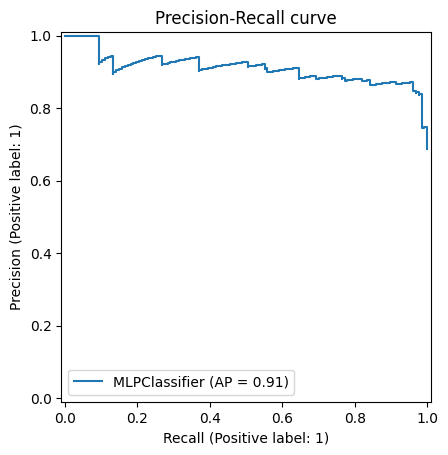

In [144]:
display = PrecisionRecallDisplay.from_estimator(mlp_best, X_test, y_test)
display.ax_.set_title("Precision-Recall curve")
plt.show()

4. Logistic Regression

Logistic Regression is a classification algorithm that predicts binary outcomes using a logistic function to model probability.

In [145]:
lr_param_dist = {
   'C': loguniform(1e-4, 1e4),      # Regularization strength
   'penalty': ['l1', 'l2'],         # Type of regularization
   'solver': ['liblinear', 'saga'], # Algorithm for optimization
}

lr = LogisticRegression(random_state=RND)

lr_random = RandomizedSearchCV(
   estimator=lr, param_distributions=lr_param_dist, n_iter=n_iter,
   cv=5, random_state=RND, n_jobs=-1, verbose=2, scoring='f1'
)

In [146]:
def logistic_regression(X_train, y_train, X_test, y_test):
  start_time = time.time()
  lr_random.fit(X_train, y_train)

  optim_time = time.time() - start_time
  print(f"\nLogisticRegression optimization took {optim_time:.2f} seconds")

  # Make predictions
  lr_best = lr_random.best_estimator_
  y_lr_pred = lr_best.predict(X_test)
  y_lr_proba = lr_best.predict_proba(X_test)
  lr_f1 = f1_score(y_test, y_lr_pred)

  # Print model evaluation metrics
  print(f"\nLogisticRegression - Test Set Performance: F1 Score: {lr_f1:.4f}")
  print(lr_best)

  # Log the experiment
  logger.log_experiment(
      experiment='Model Selection',
      model_name="LogisticRegression",
      score_before=None,
      score_after=lr_f1,
      features_before=None,
      features_after=X_train,
      duration=optim_time)
  return y_lr_pred, y_lr_proba

In [147]:
y_lr_pred, y_lr_proba = logistic_regression(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

LogisticRegression optimization took 0.24 seconds

LogisticRegression - Test Set Performance: F1 Score: 0.8993
LogisticRegression(C=np.float64(0.2854697857797185), penalty='l1',
                   random_state=42, solver='liblinear')


### Model Evaluation and Improvement

If the goal of this article were solely to find the best model, we would spend more time fine-tuning the parameter space. Instead, let's focus on understanding what is "the best model" for a classification problem.

In [148]:
def evaluate_model(y_test, y_pred, y_pred_proba):
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Classification Report (includes precision, recall, f1 per class)
    print(classification_report(y_test, y_pred))

    # ROC-AUC Score
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    # Precision-Recall AUC (especially important for imbalanced data)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    pr_auc = auc(recall, precision)

    return cm, roc_auc, pr_auc

In [149]:
evaluate_model(y_test, y_dt_pred, y_dt_proba)

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        58
           1       0.88      0.97      0.92       127

    accuracy                           0.89       185
   macro avg       0.89      0.84      0.86       185
weighted avg       0.89      0.89      0.88       185



(array([[ 41,  17],
        [  4, 123]]),
 np.float64(0.8416372522400217),
 np.float64(0.9352240721341728))

**Model Performance Metrics**

Here's how to interpret the output:

**Precision**: Out of all applications that the model predicted would be approved, 83% were actually approved.

**Recall**: Out of all applications that were actually approved, the model correctly predicted 98% of them as approved.

**F1 Score**: Combines precision and recall into a single metric, calculated as the harmonic mean of the two. An F1-score of 90% indicates that the model has a good balance between precision and recall.

**Support**: Indicates the number of instances in each class in the dataset. For example, 127 applications were approved (1 = Yes), and 58 were not approved (0 = No). It reflects the ground truth distribution.

**Accuracy**: Measures the proportion of all applications (approved and not approved) that the model classified correctly compared to the total number of applications.

**Macro Average**: Calculates the unweighted mean of precision, recall, and F1-score across all classes, treating each class equally. It does not consider class imbalance, so it can highlight performance disparities between underrepresented and dominant classes.

**Weighted Average**: The weighted average of precision, recall, and F1-score takes into account the support (number of instances) for each class. This means that classes with more data have a greater impact on the overall metric, making it particularly useful for imbalanced datasets.

https://www.statology.org/sklearn-classification-report/

In [150]:
evaluate_model(y_test, y_rf_pred, y_rf_proba)

              precision    recall  f1-score   support

           0       0.94      0.55      0.70        58
           1       0.83      0.98      0.90       127

    accuracy                           0.85       185
   macro avg       0.88      0.77      0.80       185
weighted avg       0.86      0.85      0.84       185



(array([[ 32,  26],
        [  2, 125]]),
 np.float64(0.8578604398588108),
 np.float64(0.9104878497263722))

In [151]:
evaluate_model(y_test, y_xgb_pred, y_xgb_proba)

              precision    recall  f1-score   support

           0       0.63      0.64      0.63        58
           1       0.83      0.83      0.83       127

    accuracy                           0.77       185
   macro avg       0.73      0.73      0.73       185
weighted avg       0.77      0.77      0.77       185



(array([[ 37,  21],
        [ 22, 105]]),
 np.float64(0.810073309801792),
 np.float64(0.887205668106319))

In [152]:
evaluate_model(y_test, y_mlp_pred, y_mlp_proba)

              precision    recall  f1-score   support

           0       0.92      0.59      0.72        58
           1       0.84      0.98      0.90       127

    accuracy                           0.85       185
   macro avg       0.88      0.78      0.81       185
weighted avg       0.86      0.85      0.84       185



(array([[ 34,  24],
        [  3, 124]]),
 np.float64(0.8607113765951669),
 np.float64(0.9098299447365807))

In [153]:
evaluate_model(y_test, y_lr_pred, y_lr_proba)

              precision    recall  f1-score   support

           0       0.94      0.55      0.70        58
           1       0.83      0.98      0.90       127

    accuracy                           0.85       185
   macro avg       0.88      0.77      0.80       185
weighted avg       0.86      0.85      0.84       185



(array([[ 32,  26],
        [  2, 125]]),
 np.float64(0.8275862068965516),
 np.float64(0.8830393213532004))

### Addressing Mis-classifications

In banking business, misclassification of false positive (model recommends for approval but actually be rejected) could lead to risky lending decisions and approving a bad loan is typically more costly than rejecting a good loan. Now go back to the bank director, he wants to improve the precision. Here are some approaches I explored to address this challenge

**1. Optimizing Precision During Training**

One common way is to optimize the "precision" score during hyperparameter tuning, such as using RandomizedSearchCV- I tried that and it didn't work in this case.

**2. Adjust the Classification Threshold**

The classification threshold is the probability at which the model decides to classify an instance as positive (loan approved). By default, a classification model uses a threshold of 0.5, which might not be optimal for high-risk applications like loans. I increase the threshold from 0.5 to 0.8 to make the model more conservative in predicting approvals. Only applicants with a higher likelihood of being approved (based on the model's probability) will be classified as such.

In [154]:
mlp = MLPClassifier(activation='relu', alpha=0.014, hidden_layer_sizes=(16, 16), learning_rate='constant', solver='adam', random_state=RND)
mlp.fit(X_train, y_train)

threshold = 0.8  # Set a higher threshold
y_mlp_proba = mlp.predict_proba(X_test)
y_mlp_pred = (y_mlp_proba[:, 1] >= threshold).astype(int)
mlp_f1 = f1_score(y_test, y_mlp_pred)

print(f"MLP Test Set Performance: F1 Score: {mlp_f1:.4f}")

print(classification_report(y_test, y_mlp_pred))

MLP Test Set Performance: F1 Score: 0.7500
              precision    recall  f1-score   support

           0       0.52      0.86      0.65        58
           1       0.91      0.64      0.75       127

    accuracy                           0.71       185
   macro avg       0.72      0.75      0.70       185
weighted avg       0.79      0.71      0.72       185



With a threshold of 0.8, the precision score has significantly improved. However, this comes with a trade-off. While it reduces false positives, it also rejects more qualified applicants, lowering recall from 0.98 to 0.64. Therefore, the threshold selection should align with the bank's risk tolerance and priorities.

**3. Adjust the Class weights**

Another approach is to modify the class weights to address the imbalance between the costs of different types of misclassifications. Using the dictionary `class_weights = {0: 3, 1: 1}`, I assigned a threefold higher penalty to misclassifying class 0 (unqualified applicants being approved) compared to class 1 (qualified applicants being rejected). This adjustment encourages the model to focus more on minimizing false positives, which is critical in loan approval scenarios.

The parameter `class_weight` tells the model to consider the defined weights during training, impacting the splitting criteria to account for the imbalance.

Evaluation: Use metrics like precision, recall, and F1-score to assess how well the model performs, especially under the weighted scenario.

In [155]:
# Define weights for classes
class_weights = {0: 3, 1: 1}  # Weight for 'No' (0) is higher than 'Yes' (1)

clf = DecisionTreeClassifier(class_weight=class_weights, criterion='entropy', max_depth=2, min_samples_leaf=12, min_samples_split=20,random_state=RND)  #
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        58
           1       0.88      0.97      0.92       127

    accuracy                           0.89       185
   macro avg       0.89      0.84      0.86       185
weighted avg       0.89      0.89      0.88       185



In [156]:
clf = LogisticRegression(class_weight=class_weights, penalty='l1', solver='liblinear', random_state=RND)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.64      0.76        58
           1       0.86      0.98      0.92       127

    accuracy                           0.88       185
   macro avg       0.90      0.81      0.84       185
weighted avg       0.89      0.88      0.87       185



### Handling Imbalanced Data

(This is a step in Data Preprocessing)

1. SMOTE (Synthetic Minority Oversampling Technique)

SMOTE techniques work by randomly picking a data point from a minority class and computing the K-Nearest Neighbour from that point, and adding random points between this chosen point and its neighbors. This results in a more balanced dataset, allowing the model to learn patterns from both classes more effectively.

In [157]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=RND)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution before SMOTE:", y_train.value_counts())
print("Class distribution after SMOTE:", np.bincount(y_train_smote))

Class distribution before SMOTE: Loan_Status
1    295
0    134
Name: count, dtype: int64
Class distribution after SMOTE: [295 295]


In [158]:
# SMOTE data
lr = LogisticRegression(class_weight=None, random_state=RND)  #

lr.fit(X_train_smote, y_train_smote)
y_pred = lr.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Log the experiment
logger.log_experiment(
    experiment=f'Imbalanced - SMOTE',
    model_name = "LogisticRegression",
    score_before=None,
    score_after=f1,
    features_before=None,
    features_after=X_train,
    duration=None)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.55      0.70        58
           1       0.83      0.98      0.90       127

    accuracy                           0.85       185
   macro avg       0.88      0.77      0.80       185
weighted avg       0.86      0.85      0.84       185



2. Balanced Class Weight

In [159]:
# Original Data with class_weight=None
dt = DecisionTreeClassifier(class_weight=None, random_state=RND, max_depth=2, criterion='entropy', min_samples_leaf=12, min_samples_split=20)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Log the experiment
logger.log_experiment(
    experiment=f'Imbalanced - None',
    model_name = "DecisionTreeClassifier",
    score_before=None,
    score_after=f1,
    features_before=None,
    features_after=X_train,
    duration=None)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80        58
           1       0.88      0.97      0.92       127

    accuracy                           0.89       185
   macro avg       0.89      0.84      0.86       185
weighted avg       0.89      0.89      0.88       185



In [160]:
# Original Data with class_weight='balanced'
dt = DecisionTreeClassifier(class_weight='balanced', random_state=RND, max_depth=2, criterion='entropy', min_samples_leaf=12, min_samples_split=20)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Log the experiment
logger.log_experiment(
    experiment=f'Imbalanced - balanced',
    model_name = "DecisionTreeClassifier",
    score_before=None,
    score_after=f1,
    features_before=None,
    features_after=X_train,
    duration=None)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80        58
           1       0.88      0.97      0.92       127

    accuracy                           0.89       185
   macro avg       0.89      0.84      0.86       185
weighted avg       0.89      0.89      0.88       185



**Save all experiments to log file**

In [161]:
logger.save_results("model_results")

## Conclusion
- Data preprocessing is an iterative process that requires time and refinement to prepare a robust dataset.
- Decision Trees performed better despite being simpler while complex models (MLP, RF, XGBoost) showed no advantage with this dataset.
- This result suggests that the dataset might be linearly separable or have clear decision boundaries, making simpler models more effective. In contrast, complex models risk overfitting when working with small or simple datasets. Let the data and the problem's characteristics guide your model selection. "You have to earn the complexity" - someone.
- There is no single performance metric to determine the best model, it depends on business objectives.